In [1]:
from dolo import *

In [2]:
model = yaml_import('../models/aiyagari_ind.yaml')

    calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [3]:
from dolo.numeric.processes import DiscreteMarkovProcess, MarkovProduct
r = 1.03
w = 0.956

exo = dict()
exo['z'] = DiscreteMarkovProcess([[0.9,0.1],[0.1,0.9]],[0.,1.])
exo['r'] = DiscreteMarkovProcess([[1.]],[r])
exo['w'] = DiscreteMarkovProcess([[1.]],[w])

dprocs = MarkovProduct(*[exo[k] for k in model.symbols['exogenous']]).discretize() 

In [4]:
sol = time_iteration(model, dprocess=dprocs,verbose=True)

Solving WITH complementarities.
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------


    Did not converge


|   1 |  6.772e+00 |      nan |    1.326 |  10 |
|   2 |  4.331e+00 |    0.639 |    0.094 |  10 |
|   3 |  2.327e+00 |    0.537 |    0.094 |  10 |
|   4 |  1.295e+00 |    0.556 |    0.109 |  10 |
|   5 |  8.043e-01 |    0.621 |    0.125 |  10 |
|   6 |  4.549e-01 |    0.566 |    0.125 |  10 |
|   7 |  4.216e-01 |    0.927 |    0.078 |  10 |
|   8 |  3.187e-01 |    0.756 |    0.094 |  10 |
|   9 |  2.450e-01 |    0.769 |    0.125 |  10 |
|  10 |  1.912e-01 |    0.780 |    0.125 |  10 |
|  11 |  3.858e-01 |    2.018 |    0.140 |  10 |
|  12 |  1.438e-01 |    0.373 |    0.140 |  10 |
|  13 |  3.665e-02 |    0.255 |    0.250 |  10 |
|  14 |  1.481e-01 |    4.041 |    0.109 |  10 |
|  15 |  7.268e-01 |    4.908 |    0.140 |  10 |
|  16 |  6.964e-01 |    0.958 |    0.140 |  10 |
|  17 |  6.293e-01 |    0.904 |    0.078 |  10 |
|  18 |  7.364e-01 |    1.170 |    0.078 |  10 |
|  19 |  2.901e-01 |    0.394 |    0.047 |   6 |
|  20 |  1.442e-01 |    0.497 |    0.031 |   5 |
|  21 |  7.551e-02 |

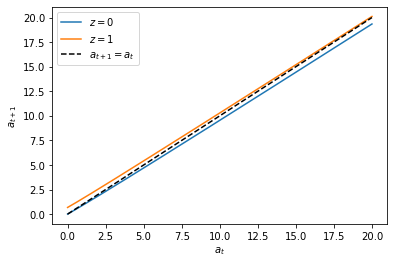

In [5]:
import matplotlib.pyplot as plt
plt.plot(sol.endo_grid.nodes(),sol(0,sol.endo_grid.nodes()))
plt.plot(sol.endo_grid.nodes(),sol(1,sol.endo_grid.nodes()))
plt.plot(sol.endo_grid.nodes(),sol.endo_grid.nodes(),'k--')
plt.xlabel("$a_t$")
plt.ylabel("$a_{t+1}$")
plt.legend(["$z = 0$","$z = 1$","$a_{t+1} = a_{t}$"])

In [6]:
def find_last(x,l):
    '''Finds the index i of a sorted list such that l[i] < x <= l[i+1]'''
    if l.size == 0:
        return -1
    else:
        h = l[0]
        t = l[1:]
        if h < x:
            return 1+find_last(x,t)
        else:
            return 0

import numpy as np

def MarkovErgodic( A ):
    """ x = xA where x is the answer
    x - xA = 0
    x( I - A ) = 0 and sum(x) = 1
    """
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.array( [0] * n + [ 1 ] ).T
    return np.linalg.lstsq( a, b )[0]

def MarkovPolicy(sol):
    n_m = sol.exo_grid.__nodes__.shape[0]
    n_s = sol.endo_grid.n[0]
    P = sol.dprocess.transitions
    n = n_m*n_s
    Q = np.zeros((n,n))
    for i_m_s in range(n):
        i_s = i_m_s % n_s
        i_m = (i_m_s-i_s) // n_s
        i_s_next = find_last(sol.coefficients[i_m][1+i_s], sol.endo_grid.__nodes__)
        for i_m_next in range(n_m):
            Q[i_m_s,i_m_next*n_s + i_s_next] += P[i_m,i_m_next]
        Q[i_m_s,:] /= np.sum(Q[i_m_s,:])
    return Q

def CapitalSupply(sol):
    Q = MarkovPolicy(sol)
    distr = MarkovErgodic(Q)
    n_m = sol.exo_grid.__nodes__.shape[0]
    grid_a = np.vstack([sol.endo_grid.__nodes__] * 2)
    return np.sum(np.dot(distr,grid_a))

In [7]:
A = 1
N = 1
alpha = 0.33
delta = 0.05

K = alpha*w*N/(1-alpha)/(delta+r-1)

def rr(K):
    return A*alpha*(N/K)**(1-alpha) - delta + 1
def ww(K):
    return A*(1-alpha)*(K/N)**(alpha)

In [8]:
import time
tol = 1e-9
adj = 0.5
s=sol
dist = 1e10
iter = 0
iter_max = 100

In [9]:
t1 = time.time()
while (dist > tol) and (iter < iter_max) :
    
    exo = dict()
    exo['z'] = DiscreteMarkovProcess([[0.9,0.1],[0.1,0.9]],[0.,1.])
    exo['r'] = DiscreteMarkovProcess([[1.]],[rr(K)])
    exo['w'] = DiscreteMarkovProcess([[1.]],[ww(K)])
    
    dprocs = MarkovProduct(*[exo[k] for k in model.symbols['exogenous']]).discretize()
    
    s = time_iteration(model, initial_guess=s, dprocess=dprocs, verbose=False)
    
    K_new = CapitalSupply(s)
    dist = abs(K-K_new)

    K = adj*K_new + (1-adj)*K
    iter += 1

    print("Iteration ",iter," : ", dist)
t2 = time.time()
print("Elapsed: {} seconds.".format(t2-t1))

    `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Iteration  1  :  13.500988861869462
Iteration  2  :  5.347963446158011
Iteration  3  :  1.0074452024764131
Iteration  4  :  0.07594133382416501
Iteration  5  :  0.006293589708489478
Iteration  6  :  0.003146794854245627
Iteration  7  :  0.0015733974271228135
Iteration  8  :  0.0007866987135614067
Iteration  9  :  0.0003933493567807034
Iteration  10  :  0.0001966746783903517
Iteration  11  :  9.833733919606402e-05
Iteration  12  :  4.916866959803201e-05
Iteration  13  :  2.4584334799016005e-05
Iteration  14  :  1.2292167399508003e-05
Iteration  15  :  6.146083698865823e-06
Iteration  16  :  3.0730418494329115e-06
Iteration  17  :  1.5365209247164557e-06
Iteration  18  :  7.682604632464063e-07
Iteration  19  :  3.8413023162320314e-07
Iteration  20  :  1.9206511581160157e-07
Iteration  21  :  9.603255790580079e-08
Iteration  22  :  4.801627895290039e-08
Iteration  23  :  2.4008139476450197e-08
Iteration  24  :  1.2004068850046679e-08
Iteration  25  :  6.002034425023339e-09
Iteration  26  

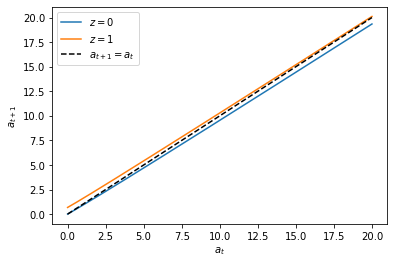

In [10]:
#Policy function
plt.plot(s.endo_grid.nodes(),sol(0,s.endo_grid.nodes()))
plt.plot(s.endo_grid.nodes(),sol(1,s.endo_grid.nodes()))
plt.plot(s.endo_grid.nodes(),sol.endo_grid.nodes(),'k--')
plt.xlabel("$a_t$")
plt.ylabel("$a_{t+1}$")
plt.legend(["$z = 0$","$z = 1$","$a_{t+1} = a_{t}$"])

In [11]:
#Asymptotic distribution of assets
def AsymptoticDistribution(sol):
    distr = MarkovErgodic(MarkovPolicy(sol))
    n_m = sol.exo_grid.__nodes__.shape[0]
    n_s = sol.endo_grid.n[0]
    n = n_m*n_s
    assets = np.zeros(n_s)
    for i_s in range(n_s):
        assets[i_s] = sum([distr[i_m*n_s + i_s] for i_m in range(n_m)])
    return assets
hist = AsymptoticDistribution(s)

    `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0.5, 1.0, 'Asymptotic density of assets')

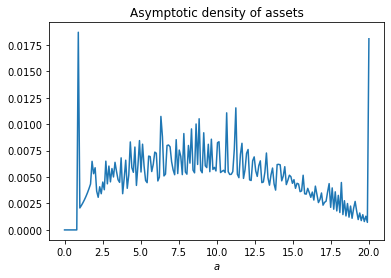

In [12]:
plt.plot(s.endo_grid.nodes(),hist)
plt.xlabel("$a$")
plt.title("Asymptotic density of assets")

In [13]:
K

9.49028807971862